In [1]:
import wfdb
from biosppy.signals import ecg
from sklearn.preprocessing import MinMaxScaler

In [4]:
import numpy as np
import matplotlib.pyplot as plt

#### 1. Import raw signal

In [3]:
user_id = 21
filename = f'../data/raw/autonomic-aging-cardiovascular/1.0.0/{user_id:04d}'
record = wfdb.rdrecord(filename)
raw_signal = record.p_signal[:, 0]
fs = record.fs

#### Visualise signal spectrum

In [28]:
# Calculate the spectrum of the signal using fft
fft_result = np.fft.fft(raw_signal)
frequencies = np.fft.fftfreq(len(raw_signal), d=1/fs)
magnitude = np.abs(fft_result)
magnitude_db = 20 * np.log10(magnitude)

# Keep only the positive frequencies
positive_frequencies = frequencies[:len(frequencies)//2]
positive_magnitude_db = magnitude_db[:len(magnitude_db)//2]

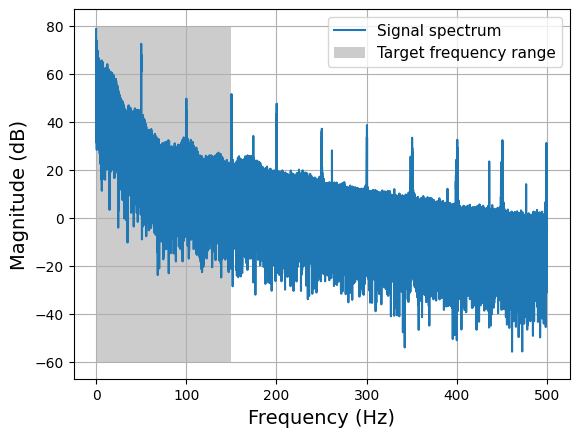

In [26]:
fig, ax = plt.subplots()
ax.plot(positive_frequencies, positive_magnitude_db, label='Signal spectrum')
ax.set_xlabel('Frequency (Hz)', fontsize=14)
ax.set_ylabel('Magnitude (dB)', fontsize=14)
ax.fill_between([0.67, 150], -60, 80, color='black', alpha=0.2, edgecolor=None, label='Target frequency range')
ax.grid()
ax.legend(fontsize=11)
plt.savefig(f'../figures/ecg_spectrum.pdf', bbox_inches='tight')
plt.show()

#### 2. Visualise FIR filter

In [13]:
import numpy as np
from scipy.signal import firwin, freqz

In [114]:
sampling_rate = 1000.0
order = int(0.3 * sampling_rate)
frequency=np.array([0.67, 150], dtype=float)

In [115]:
wn = 2.0 * frequency / sampling_rate

In [116]:
if order % 2 == 0:
    order = order + 1
a = np.array([1])
b = firwin(numtaps=order, cutoff=wn, pass_zero=False)

In [117]:
w, h = freqz(b, a)
frequencies = sampling_rate * w / (2 * np.pi)
h_dB = 20 * np.log10(abs(h))
h_angle = np.unwrap(np.angle(h))

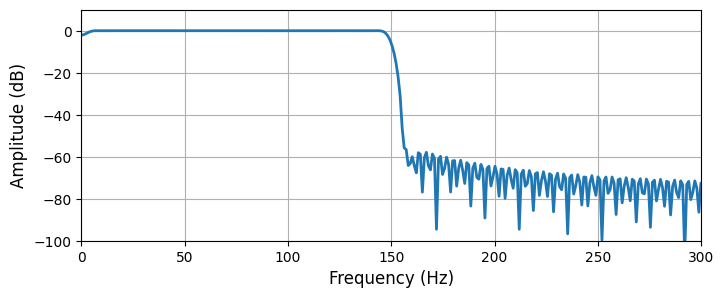

In [118]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(frequencies, h_dB, 'tab:blue', linewidth=2)
ax.set_xlabel('Frequency (Hz)', fontsize=12)
ax.set_ylabel('Amplitude (dB)', fontsize=12)
ax.set_xlim(0, 300)
ax.set_ylim(-100, 10)
ax.grid()
fig.savefig('../figures/fir_frequency_response.pdf', bbox_inches='tight')
plt.show()

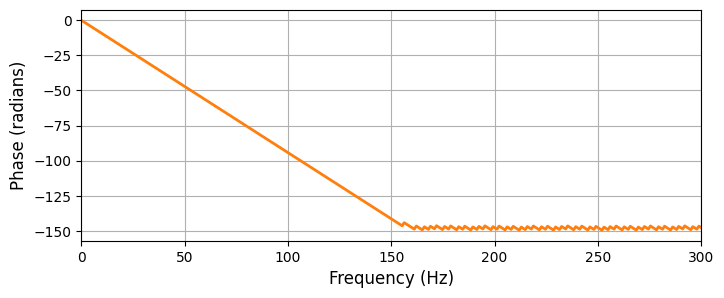

In [98]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(frequencies, h_angle, color='tab:orange', linewidth=2)
ax.set_xlabel('Frequency (Hz)', fontsize=12)
ax.set_ylabel('Phase (radians)', fontsize=12)
ax.set_xlim(0, 300)
ax.grid()
fig.savefig('../figures/fir_phase_response.pdf', bbox_inches='tight')
plt.show()

#### 3. Signal processing with biosspy

In [27]:
ecg_dict = ecg.ecg(signal=raw_signal, sampling_rate=fs, show=False)
filtered_signal = ecg_dict['filtered']
rpeaks = ecg_dict['rpeaks']
time_arr = ecg_dict['ts']

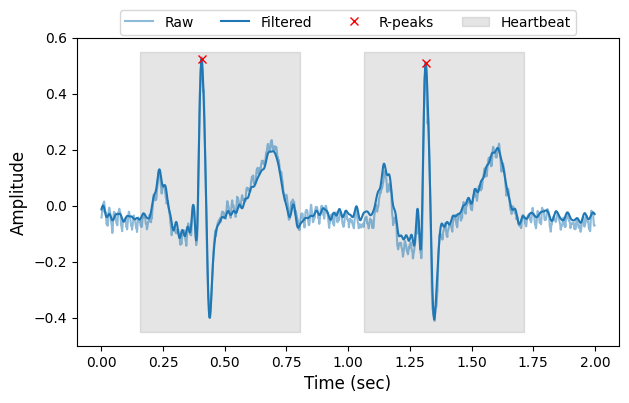

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

time_offset = time_arr[2600]
selected_time = time_arr[2600:4600] - time_offset
selected_raw = raw_signal[2600:4600]
selected_filtered = filtered_signal[2600:4600]
selected_rpeaks = rpeaks[2:4]

ax.plot(selected_time, selected_raw, color='tab:blue', alpha=0.5, label='Raw')
ax.plot(selected_time, selected_filtered, color='tab:blue', label='Filtered')
ax.plot(
    time_arr[selected_rpeaks]-time_offset,
    filtered_signal[selected_rpeaks],
    'rx',
    label='R-peaks'
)

ax.fill_betweenx(
    [-0.45,0.55],
    time_arr[selected_rpeaks[0]-250]-time_offset, time_arr[selected_rpeaks[0]+400]-time_offset,
    color='black', alpha=0.1,
    label='Heartbeat'
)
ax.fill_betweenx(
    [-0.45, 0.55],
    time_arr[selected_rpeaks[1]-250]-time_offset, time_arr[selected_rpeaks[1]+400]-time_offset,
    color='black', alpha=0.1
)

ax.legend(ncols=4, bbox_to_anchor=(0.5, 1.05), loc='center', fontsize=10)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.set_ylabel('Amplitude', fontsize=12)
plt.savefig('../figures/ecg_rpeaks.pdf', bbox_inches='tight')
plt.show()

#### 4. Visualise templates and scaling

In [105]:
templates = ecg_dict['templates']
templates_ts = ecg_dict['templates_ts'] - ecg_dict['templates_ts'][0]
scaled_templates = MinMaxScaler().fit_transform(templates.T).T

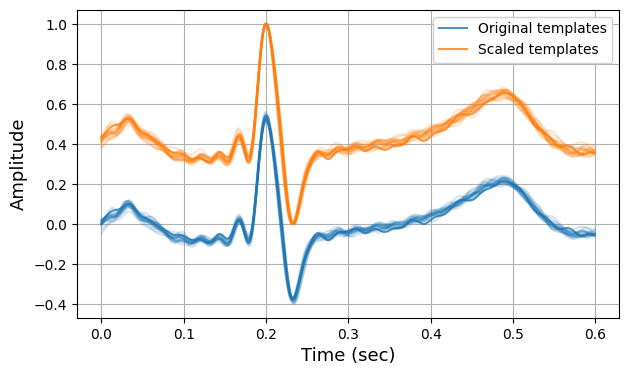

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
for i in range(10, 30):
    if i == 10:
        ax.plot(templates_ts, templates[i], color='tab:blue', alpha=0.8, label='Original templates')
        ax.plot(templates_ts, scaled_templates[i], color='tab:orange', alpha=0.8, label='Scaled templates')
    else:
        ax.plot(templates_ts, templates[i], color='tab:blue', alpha=0.2)
        ax.plot(templates_ts, scaled_templates[i], color='tab:orange', alpha=0.2)
ax.legend(framealpha=0.9)
ax.grid()
ax.set_xlabel('Time (sec)', fontsize=13)
ax.set_ylabel('Amplitude', fontsize=13)
plt.savefig('../figures/ecg_templates.pdf', bbox_inches='tight')
plt.show()